In [2]:
import pandas as pd
pd.set_option('display.width', 10000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")


In [3]:
mwoz = pd.read_csv("../data/output/mwoz_1processed.csv")
mwoz.head(5)

,speaker,text,domain-intent,rating 1,rating 2,rating 3,rating 4,rating 5,domain,intent,avg_rating,conv_ID,turn_id,wt_avg_rating,word_count,satisfaction_rating
0,USER,I'm looking for a cheap restaurant in the east...,Restaurant-Inform,3.0,3.0,3.0,3.0,NaN,Restaurant,Inform,3.0,0,0,3.0,12,Medium
1,SYSTEM,the missing sock is a nice restaurant in the e...,Restaurant-Inform,NaN,NaN,NaN,NaN,NaN,Restaurant,Inform,NaN,0,1,NaN,18,Medium
2,USER,What is the address and phone number?,Restaurant-Request,3.0,3.0,3.0,3.0,NaN,Restaurant,Request,3.0,0,2,3.0,7,Medium
3,SYSTEM,The address of The Missing Sock is Finders Cor...,general-reqmore,NaN,NaN,NaN,NaN,NaN,general,reqmore,NaN,0,3,NaN,26,Medium
4,USER,Does this restaurant have highchairs for babies?,NaN,3.0,3.0,3.0,3.0,NaN,NaN,NaN,3.0,0,4,3.0,7,Medium


### Setup Eval Metrics

In [33]:
# mwoz['dummy_rating']= "Medium"
# mwoz['dummy_score'] = 3



In [31]:
# # from utils import calculate_metrics
# # calculate_metrics(mwoz, 'satisfaction_rating','dummy_rating')

# from utils import evaluate_model_performance


# # If wt_avg_rating and predicted_satisfaction are categorical
# metrics = evaluate_model_performance(
#     mwoz, 'satisfaction_rating', 'dummy_rating', labels=['Low', 'Medium', 'High']
# )
# print(metrics)

### Setup Features

In [80]:
#FEATURE: add sentiment per turn

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    """Function to classify sentiment based on VADER compound score"""
    if pd.isna(text):  # Handle missing values
        return "Neutral"
    scores = analyzer.polarity_scores(text)
    if scores["compound"] >= 0.05:
        return "Positive"
    elif scores["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

mwoz["sentiment"] = mwoz["text"].apply(classify_sentiment)


In [81]:
#FEATURE Measure politeness
def measure_politeness(text):
    politeness_phrases = ["please", "thank you", "would you mind", "could you", "I appreciate"]
    softeners = ["might", "perhaps", "possibly", "I was wondering if"]
    
    politeness_score = sum(1 for phrase in politeness_phrases if phrase in text.lower())
    softener_score = sum(1 for word in softeners if word in text.lower())
    
    return politeness_score + softener_score

mwoz["politeness"] = mwoz["text"].apply(measure_politeness)


In [82]:
#FEATURE: clause to sentence ratio
import spacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")

def calculate_clause_to_sentence_ratio(text):
    """
    Calculate the Clause-to-Sentence Ratio for a given text.
    """
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    num_clauses = 0

    for token in doc:
        # Identify clause indicators like VERB, AUX (auxiliary verbs)
        if token.dep_ in {"ROOT", "csubj", "csubjpass", "advcl", "relcl"}:
            num_clauses += 1

    # Avoid division by zero
    return num_clauses / num_sentences if num_sentences > 0 else 0

# Apply the function to the text column
mwoz["clause_to_sentence_ratio"] = mwoz["text"].apply(calculate_clause_to_sentence_ratio)


In [83]:
#FEATURE: 
def calculate_dialogue_depth(text):
    """
    Approximate dialogue depth by counting references to prior context.
    This is a simplified metric based on pronouns and discourse markers.
    """
    # Pronouns and discourse markers indicative of context dependency
    context_markers = {"he", "she", "it", "they", "this", "that", "these", "those", 
                       "because", "therefore", "however", "but", "so"}
    
    doc = nlp(text)
    depth = 0

    for token in doc:
        if token.text.lower() in context_markers:
            depth += 1

    return depth

# Apply the function to the text column
mwoz["dialogue_depth"] = mwoz["text"].apply(calculate_dialogue_depth)


In [84]:
mwoz['dialogue_depth'].value_counts()

dialogue_depth
0    14369
1     6999
2     1477
3      225
4       33
5        3
6        2
Name: count, dtype: int64

In [85]:
# FEATURE: 
def calculate_lexical_diversity(text):
    """
    Calculate the Type-Token Ratio (TTR) for a given text.
    """
    tokens = text.split()  # Split text into tokens
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if tokens else 0

# Apply the function to the text column
mwoz["lexical_diversity"] = mwoz["text"].apply(calculate_lexical_diversity)


In [86]:
import nltk
from nltk.corpus import brown

# Download Brown corpus
nltk.download("brown")

# Create a frequency distribution from the Brown corpus
brown_words = brown.words()
freq_dist = nltk.FreqDist(brown_words)

# Define thresholds for rare and common words
common_threshold = 1000  # Common if frequency > 1000
rare_threshold = 10      # Rare if frequency < 10

# Function to calculate rare/common word ratio
def calculate_rare_common_ratio(text):
    tokens = text.split()
    rare_count = sum(1 for token in tokens if freq_dist[token.lower()] < rare_threshold)
    common_count = sum(1 for token in tokens if freq_dist[token.lower()] > common_threshold)
    total_count = len(tokens)
    return {
        "rare_ratio": rare_count / total_count if total_count else 0,
        "common_ratio": common_count / total_count if total_count else 0
    }

# Apply the function to the text column
rare_common_ratios = mwoz["text"].apply(calculate_rare_common_ratio)

# Split the results into separate columns
mwoz["rare_ratio"] = rare_common_ratios.apply(lambda x: x["rare_ratio"])
mwoz["common_ratio"] = rare_common_ratios.apply(lambda x: x["common_ratio"])


[nltk_data] Downloading package brown to /Users/RiRi/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [87]:
mwoz.domain.unique().tolist()

['Restaurant',
 'general',
 nan,
 'Attraction',
 'Hotel',
 'Booking',
 'Taxi',
 'Train',
 'Hospital',
 'Police']

In [88]:
#Code for Punctuation Counts and Stopword Ratios

import string
from nltk.corpus import stopwords
import nltk

# Ensure the required NLTK data is downloaded
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words("english"))

# Sample DataFrame for demonstration (replace with your actual data)
# mwoz = pd.DataFrame({"text": ["Hello! How are you?", "I'm fine. Thank you!", "Why...?"]})

# Function to calculate punctuation counts
def count_punctuation(text):
    punctuation_counts = {
        "?": text.count("?"),
        "!": text.count("!"),
        "...": text.count("...")
    }
    return punctuation_counts

# Function to calculate stopword ratio
def calculate_stopword_ratio(text):
    words = text.split()  # Split text into words
    stopword_count = sum(1 for word in words if word.lower() in stop_words)
    total_words = len(words)
    return stopword_count / total_words if total_words > 0 else 0

# Apply the functions to the text column
mwoz["punctuation_counts"] = mwoz["text"].apply(count_punctuation)
mwoz["stopword_ratio"] = mwoz["text"].apply(calculate_stopword_ratio)

# Split punctuation counts into separate columns
punct_df = mwoz["punctuation_counts"].apply(pd.Series)
mwoz = pd.concat([mwoz, punct_df], axis=1).drop(columns=["punctuation_counts"])

# Display the DataFrame
print(mwoz)


[nltk_data] Downloading package stopwords to /Users/RiRi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      speaker                                               text       domain-intent  rating 1  rating 2  rating 3  rating 4  rating 5      domain   intent  ...  politeness  clause_to_sentence_ratio  dialogue_depth  lexical_diversity  rare_ratio common_ratio stopword_ratio  ?  !  ...
0        USER  I'm looking for a cheap restaurant in the east...   Restaurant-Inform       3.0       3.0       3.0       3.0       NaN  Restaurant   Inform  ...           0                       1.0               0           1.000000    0.166667     0.416667       0.416667  0  0    0
1      SYSTEM  the missing sock is a nice restaurant in the e...   Restaurant-Inform       NaN       NaN       NaN       NaN       NaN  Restaurant   Inform  ...           0                       1.0               0           0.833333    0.055556     0.444444       0.444444  0  0    0
2        USER              What is the address and phone number?  Restaurant-Request       3.0       3.0       3.0       3.0       NaN  Restauran

In [89]:
mwoz.to_csv('../data/output/features.csv')


### Naive Approach 0: Regression

In [2]:
import pandas as pd
mwoz= pd.read_csv('../data/output/features.csv')
mwoz = mwoz.drop(columns=['Unnamed: 0', 'common_ratio'])

# train = pd.read_csv('../data/output/train.csv')
# test = pd.read_csv('../data/output/test.csv')


In [3]:
LOW = mwoz[mwoz['satisfaction_rating']=='Low']
# LOW.to_csv('../data/output/low_rating.csv')
HIGH =mwoz[mwoz['satisfaction_rating']=='High'] 
# HIGH.to_csv('../data/output/high_rating.csv')
MED =mwoz[mwoz['satisfaction_rating']=='Medium'] 
print(LOW.shape[0], HIGH.shape[0], MED.shape[0])

2748 2754 17606


In [100]:
# mwoz['pred0'] = 3

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import sqrt

data = mwoz.copy()
data[(data['speaker']=='USER') & (data['text'] != 'OVERALL')]
# Define the target column
target = 'wt_avg_rating'

# Drop irrelevant or non-predictive columns
data_cleaned = data.drop(columns=['Unnamed: 0', 'conv_ID', 'turn_id',
                                    'avg_rating', 'rating 1', 'rating 2', 'rating 3', 'rating 4', 'rating 5',
                                    'satisfaction_rating', 'intent', 'common_ratio',
                                    'satisfaction_rating_High', 'satisfaction_rating_Low',
                                    'speaker', 'text', 'domain-intent', 'domain'], errors='ignore')

data_cleaned = data_cleaned.dropna(subset=[target])


X = data_cleaned.drop(columns=[target])
y = data_cleaned[target]

# Handle missing values in features
X.fillna(X.median(numeric_only=True), inplace=True)
X.fillna(X.mode().iloc[0], inplace=True)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Split data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = round(mean_squared_error(y_test, y_pred),3)
rmse = sqrt(mse)
print(f"Mean Squared Error for wt_avg_rating prediction: {mse}")
print(f"Root Mean Squared Error for wt_avg_rating prediction: {rmse}")


Mean Squared Error for wt_avg_rating prediction: 0.135
Root Mean Squared Error for wt_avg_rating prediction: 0.3674234614174767


(0.0, 5.0)

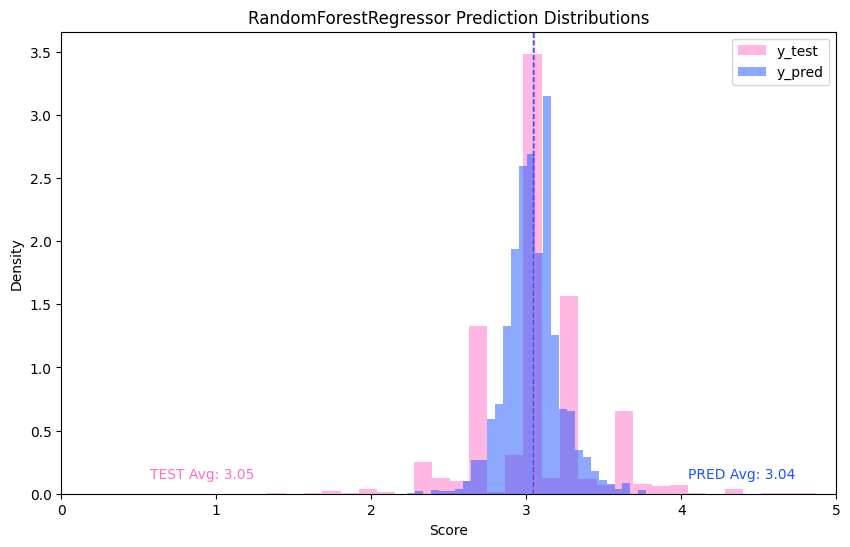

In [21]:
#VIZ distribution of word count, slice by user vs system

# mwoz = pd.read_csv('../data/output/mwoz_1processed.csv')
# Define custom colors for User and System
user_color = "#FF6EC7"  # Pink (Valence theme)
system_color = "#1A53FF"  # Blue (Valence theme)

# Filter data by speaker
user_word_counts = y_test
system_word_counts = y_pred

# Calculate averages for User and System
user_avg = user_word_counts.mean()
system_avg = system_word_counts.mean()


# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(user_word_counts, bins=30, alpha=0.5, label="test", density=True, color=user_color)
plt.hist(system_word_counts, bins=30, alpha=0.5, label="pred", density=True, color=system_color)

# Add average lines
plt.axvline(user_avg, color=user_color, linestyle="dashed", linewidth=1)
plt.axvline(system_avg, color=system_color, linestyle="dashed", linewidth=1)

# Add labels to the average lines
plt.text(user_avg - 1.8, 0.12, f"TEST Avg: {user_avg:.2f}", color=user_color, fontsize=10, ha="right")
plt.text(system_avg + 1, 0.12, f"PRED Avg: {system_avg:.2f}", color=system_color, fontsize=10, ha="left")

# Add title, labels, and legend
plt.title("RandomForestRegressor Prediction Distributions")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend(["y_test", "y_pred"])  # Only speakers in legend, no averages
plt.xlim(0, 5)  # Adjust the x-axis range for a shorter word count axis
# plt.show()


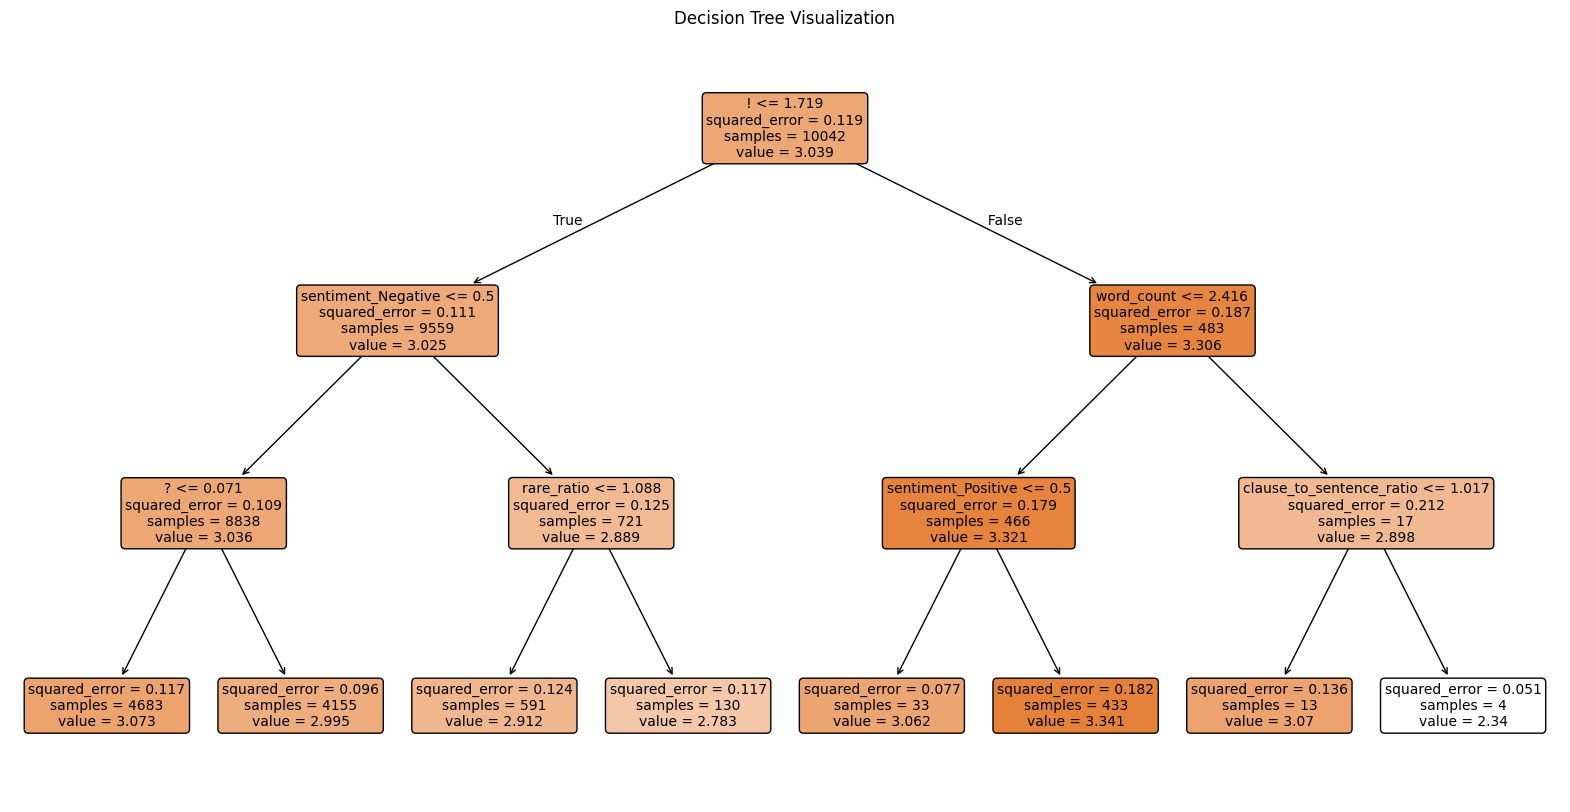

In [11]:
#VIZ just an example of a regression tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Preprocess the data separately
X_preprocessed = preprocessor.fit_transform(X_train)

# Combine numerical and categorical column names after preprocessing
# For OneHotEncoder, get the generated feature names
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols.tolist() + categorical_feature_names.tolist()

# Fit the DecisionTreeRegressor directly
tree_model = DecisionTreeRegressor(random_state=42, max_depth=3)  # Limit depth for visualization
tree_model.fit(X_preprocessed, y_train)

# Plot the regression tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=all_feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


In [19]:
numerical_cols

Index(['word_count', 'politeness', 'clause_to_sentence_ratio', 'dialogue_depth', 'lexical_diversity', 'rare_ratio', 'common_ratio', 'stopword_ratio', '?', '!', '...'], dtype='object')

In [139]:
# print(X[['conv_ID', 'turn_id']].corrwith(y))


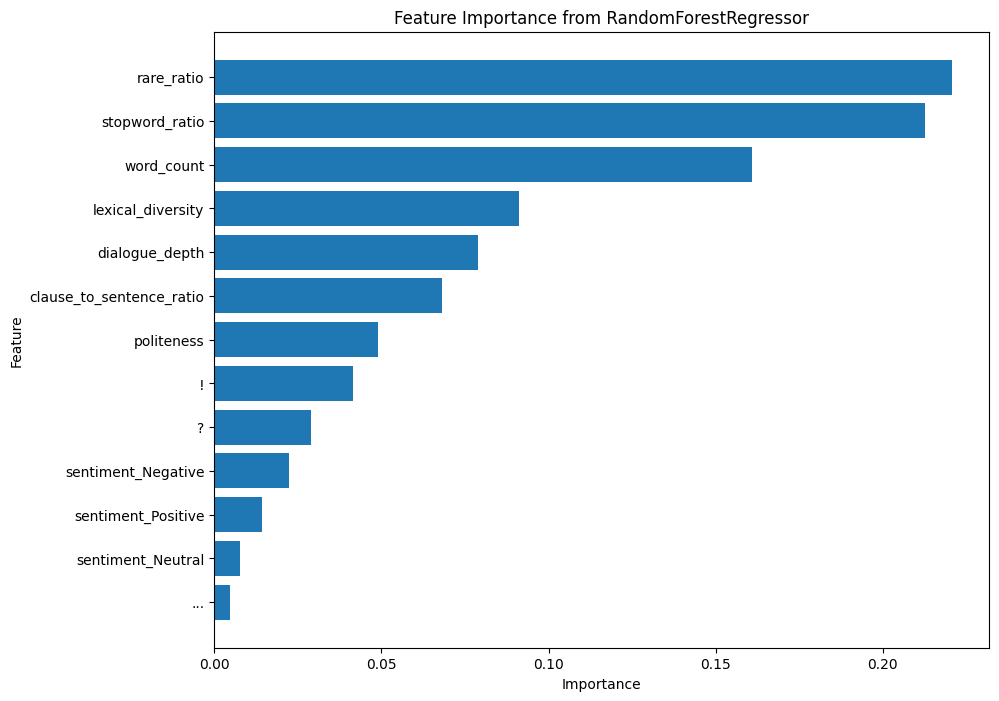

,Feature,Importance
5,rare_ratio,0.220772
6,stopword_ratio,0.212442
0,word_count,0.160708
4,lexical_diversity,0.091114
3,dialogue_depth,0.078804
2,clause_to_sentence_ratio,0.068120
1,politeness,0.048930
8,!,0.041538
7,?,0.028825
10,sentiment_Negative,0.022213


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the RandomForestRegressor
regressor = model.named_steps['regressor']
feature_importances = regressor.feature_importances_

# Retrieve feature names from the preprocessor
# Get the numeric feature names
numerical_feature_names = numerical_cols.tolist()

# Get the one-hot encoded feature names
categorical_feature_names = model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

# Combine numerical and categorical feature names
all_feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from RandomForestRegressor')
plt.gca().invert_yaxis()
plt.show()

# Display the feature importance DataFrame
feature_importance_df


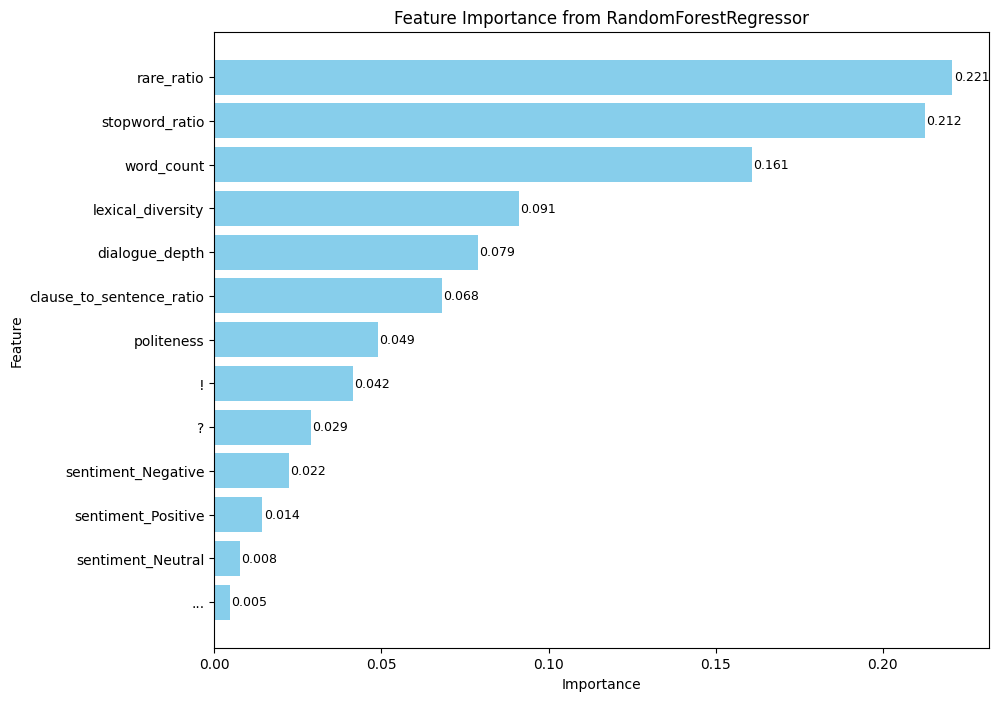

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the RandomForestRegressor
regressor = model.named_steps['regressor']
feature_importances = regressor.feature_importances_

# Retrieve feature names from the preprocessor
# Get the numeric feature names
numerical_feature_names = numerical_cols.tolist()

# Get the one-hot encoded feature names
categorical_feature_names = model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

# Combine numerical and categorical feature names
all_feature_names = numerical_feature_names + categorical_feature_names.tolist()

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

# Add annotations (importance values) along the right side of each bar, centered vertically
for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(
        bar.get_width() + 0.0004,  # Slightly beyond the end of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered
        f"{importance:.3f}",  # Format importance to 3 decimal places
        ha='left',  # Align text to the left of the annotation point
        va='center',  # Vertically centered alignment
        fontsize=9  # Font size
    )

# Label axes and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from RandomForestRegressor')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


In [143]:
# import shap
# import matplotlib.pyplot as plt

# # Extract the fitted regressor and preprocessor
# regressor = model.named_steps['regressor']
# preprocessor = model.named_steps['preprocessor']

# # Preprocess the training data (for SHAP compatibility)
# X_train_preprocessed = preprocessor.transform(X_train)

# # Create a SHAP explainer
# explainer = shap.TreeExplainer(regressor)

# # Compute SHAP values
# shap_values = explainer.shap_values(X_train_preprocessed)

# # Combine feature names (numerical + one-hot encoded categorical features)
# numerical_feature_names = numerical_cols.tolist()
# categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
# all_feature_names = numerical_feature_names + categorical_feature_names.tolist()

# # Create SHAP summary plot
# shap.summary_plot(shap_values, X_train_preprocessed, feature_names=all_feature_names)

# # Optional: SHAP bar plot for feature importance
# shap.summary_plot(shap_values, X_train_preprocessed, feature_names=all_feature_names, plot_type="bar")


conv_ID   -0.145891
turn_id    0.071504
dtype: float64


In [70]:
# #Composite Score=(0.4×wt_avg_rating)+(0.2×sentiment)+(0.2×satisfaction_rating)+(0.1×politeness)+(0.1×dialogue_depth)
# data = mwoz.copy()
# # Ensure numeric types for all columns before normalization
# data['wt_avg_rating'] = pd.to_numeric(data['wt_avg_rating'], errors='coerce')
# data['sentiment'] = pd.to_numeric(data['sentiment'], errors='coerce')
# data['satisfaction_rating'] = pd.to_numeric(data['satisfaction_rating'], errors='coerce')
# data['politeness'] = pd.to_numeric(data['politeness'], errors='coerce')
# data['dialogue_depth'] = pd.to_numeric(data['dialogue_depth'], errors='coerce')

# # Fill any remaining NaNs with 0
# data[['wt_avg_rating', 'sentiment', 'satisfaction_rating', 'politeness', 'dialogue_depth']] = \
#     data[['wt_avg_rating', 'sentiment', 'satisfaction_rating', 'politeness', 'dialogue_depth']].fillna(0)

# # Normalize the values to a 0-1 scale, handling constant columns
# for column in ['wt_avg_rating', 'sentiment', 'satisfaction_rating', 'politeness', 'dialogue_depth']:
#     col_min, col_max = data[column].min(), data[column].max()
#     if col_min == col_max:  # Handle constant column
#         data[column] = 0  # Set to 0 since all values are identical
#     else:
#         data[column] = (data[column] - col_min) / (col_max - col_min)

# # Redefine the weights for the composite score
# weights = {'wt_avg_rating': 0.4, 'sentiment': 0.2, 'satisfaction_rating': 0.2, 'politeness': 0.1, 'dialogue_depth': 0.1}

# # Calculate the composite score using the weighted sum of normalized features
# data['composite_score'] = (
#     weights['wt_avg_rating'] * data['wt_avg_rating'] +
#     weights['sentiment'] * data['sentiment'] +
#     weights['satisfaction_rating'] * data['satisfaction_rating'] +
#     weights['politeness'] * data['politeness'] +
#     weights['dialogue_depth'] * data['dialogue_depth']
# )

# # Display the updated dataset
# data[['wt_avg_rating', 'sentiment', 'satisfaction_rating', 'politeness', 'dialogue_depth', 'composite_score']].head()




,wt_avg_rating,sentiment,satisfaction_rating,politeness,dialogue_depth,composite_score
0,0.514286,0,0,0.0,0.000000,0.205714
1,0.000000,0,0,0.0,0.000000,0.000000
2,0.514286,0,0,0.0,0.000000,0.205714
3,0.000000,0,0,0.0,0.000000,0.000000
4,0.514286,0,0,0.0,0.166667,0.222381


In [61]:
# #TODO keep or not
# # from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation, NMF
# import pandas as pd

# # Example DataFrame (replace with your actual data)
# # mwoz = pd.DataFrame({"text": ["Book a reservation", "Can I confirm my appointment?", "Need a time for Friday"]})

# # Step 1: Preprocess and Vectorize Text
# vectorizer = TfidfVectorizer(max_features=500, stop_words="english")  # Adjust max_features as needed
# tfidf_matrix = vectorizer.fit_transform(mwoz["text"])

# count_vectorizer = CountVectorizer(max_features=500, stop_words="english")  # For LDA
# count_matrix = count_vectorizer.fit_transform(mwoz["text"])

# # Step 2: Define the number of topics
# num_topics = 5  # Adjust as needed

# # Step 3: Apply LDA (Count-based)
# lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
# lda_topics = lda.fit_transform(count_matrix)

# # Step 4: Apply NMF (TF-IDF-based)
# nmf = NMF(n_components=num_topics, random_state=42)
# nmf_topics = nmf.fit_transform(tfidf_matrix)

# # Step 5: Extract and Display Top Words for Each Topic
# def display_topics(model, feature_names, num_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
#         top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
#         print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# print("LDA Topics:")
# display_topics(lda, count_vectorizer.get_feature_names_out())

# print("\nNMF Topics:")
# display_topics(nmf, vectorizer.get_feature_names_out())


LDA Topics:
Topic 1: number, help, reference, thank, need, phone, today, address, great, postcode
Topic 2: like, area, sorry, food, town, centre, try, restaurant, price, restaurants
Topic 3: book, need, overall, yes, people, train, like, nights, restaurant, taxi
Topic 4: free, time, parking, like, wifi, does, house, day, book, hotel
Topic 5: hotel, restaurant, looking, need, place, stay, does, price, like, range

NMF Topics:
Topic 1: overall, food, type, serves, restaurants, serve, indian, british, italian, try
Topic 2: hotel, restaurant, free, price, looking, range, does, parking, area, wifi
Topic 3: thank, help, need, today, goodbye, great, thanks, needed, day, bye
Topic 4: number, reference, phone, help, booking, successful, booked, postcode, address, today
Topic 5: book, like, yes, need, people, train, time, nights, reservation, starting


In [36]:
# #FEATURE: empathy using opensource model
# # Jochen Hartmann, "Emotion English DistilRoBERTa-base". https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/, 2022.


# from transformers import pipeline

# classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

# def classify_empathy(text):
#     """Function to classify empathy based on emotion labels"""
#     if pd.isna(text):
#         return 0  # Assign 0 for missing text
#     result = classifier(text)[0]  # Get the classification result
#     if result["label"] in ["compassion", "love", "sadness"]:  # Empathy-related emotions
#         return result["score"]
#     return 0

# mwoz["empathy_score"] = mwoz["text"].apply(classify_empathy)
# print(mwoz[["text", "empathy_score"]].head())


KeyboardInterrupt: 

In [ ]:
# mwoz.to_csv("../data/output/mwoz_0features.csv", index=False)

In [ ]:
#VIZ empathy
non_zero_empathy_scores = mwoz[mwoz["empathy_score"] > 0]["empathy_score"]

plt.figure(figsize=(10, 6))
plt.hist(non_zero_empathy_scores, bins=20, color="skyblue", alpha=0.8, edgecolor="black")
plt.title("Distribution of Empathy Scores")
plt.xlabel("Empathy Score")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [38]:
#FEATURE CONVO level measure task resolution - 
mwoz["resolved"] = mwoz["intent"].notna()  # Assuming non-NA 'intent' indicates task presence
# Calculate task resolution rate per conversation
task_resolution_rate = mwoz.groupby("conv_ID")["resolved"].mean()
# Create a new column to store the resolution rate for "OVERALL" rows only
mwoz["task_resolution_rate"] = None
mwoz.loc[mwoz["text"] == "OVERALL", "task_resolution_rate"] = mwoz.loc[mwoz["text"] == "OVERALL", "conv_ID"].map(task_resolution_rate)

# print(mwoz[["conv_ID", "text", "resolved", "task_resolution_rate"]].head(30))


In [ ]:
#VIZ

# Filter rows containing "OVERALL" in the "text" column
overall_rows = mwoz[mwoz["text"] == "OVERALL"]
resolution_rates = overall_rows["task_resolution_rate"].dropna().astype(float)


plt.figure(figsize=(10, 6))
plt.hist(resolution_rates, bins=10, color="skyblue", alpha=0.8, edgecolor="black")
plt.title("Distribution of Task Resolution Rates (OVERALL Rows)")
plt.xlabel("Task Resolution Rate")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
mwoz.head()

* sentiment 
* politeness
* empathy 
* task_resolution_rate